<a href="https://colab.research.google.com/github/dairycowp/HAR_ST/blob/main/%E2%80%9CHuman_Activity_Recognition%E2%80%9D%E7%9A%84%E5%89%AF%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#   This software component is licensed by ST under BSD-3-Clause license,
#   the "License"; You may not use this file except in compliance with the
#   License. You may obtain a copy of the License at:
#             https://opensource.org/licenses/BSD-3-Clause

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1IPI1eD264yFG0eHiyhg2wfVlzyRf1E0Y#scrollTo=hzWLuhG3EI6R)

# Human Activity Recognition

This notebook shows the process of creating a basic motion sensing activity classifier model, using Keras, for STM32 embedded applications.


## Import TensorFlow

Use TensorFlow 2.5.0 to be aligned with X-CUBE-AI v7.0.0.

In [41]:
import tensorflow as tf
print(tf.version.VERSION)

2.17.1


In [42]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Loading the dataset

The dataset is composed of 3-axis acceleration values stored in `.csv` text format. Each individual file corresponds to a capture characterised by it's containing folder name.

Download and extract the dataset:

In [ ]:
'''!wget -nc https://github.com/STMicroelectronics/stm32ai/raw/master/AI_resources/HAR/dataset.zip'''

--2021-06-30 14:08:47--  https://github.com/STMicroelectronics/stm32ai/raw/master/AI_resources/HAR/dataset.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/STMicroelectronics/stm32ai/master/AI_resources/HAR/dataset.zip [following]
--2021-06-30 14:08:47--  https://raw.githubusercontent.com/STMicroelectronics/stm32ai/master/AI_resources/HAR/dataset.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 529341 (517K) [application/zip]
Saving to: ‘dataset.zip’

dataset.zip         100%[===================>] 516.93K  --.-KB/s    in 0.04s   

2021-06-30 14:08:47 (12.0 MB/s) - ‘dataset.zip’ saved [5293

In [ ]:
'''!unzip -n dataset.zip'''

Archive:  dataset.zip
   creating: dataset/
  inflating: dataset/LICENSE         
  inflating: dataset/README.md       
   creating: dataset/running/
  inflating: dataset/running/running_01_26Hz_4g_mg.csv  
  inflating: dataset/running/running_02_26Hz_4g_mg.csv  
  inflating: dataset/running/running_03_26Hz_4g_mg.csv  
  inflating: dataset/running/running_04_26Hz_4g_mg.csv  
  inflating: dataset/running/running_05_26Hz_4g_mg.csv  
  inflating: dataset/running/running_06_26Hz_4g_mg.csv  
  inflating: dataset/running/running_07_26Hz_4g_mg.csv  
  inflating: dataset/running/running_08_26Hz_4g_mg.csv  
  inflating: dataset/running/running_09_26Hz_4g_mg.csv  
  inflating: dataset/running/running_10_26Hz_4g_mg.csv  
  inflating: dataset/running/running_12_26Hz_4g_mg.csv  
  inflating: dataset/running/running_13_26Hz_4g_mg.csv  
  inflating: dataset/running/running_14_26Hz_4g_mg.csv  
  inflating: dataset/running/running_15_26Hz_4g_mg.csv  
  inflating: dataset/running/running_16_26Hz_4g_mg.c

Load the dataset into memory:

In [45]:
import glob
import numpy as np

# Load data into memory
labels = ['Run', 'WalkDown', 'WalkForward', 'WalkLeft', 'WalkRight', 'WalkUp']
x_recordings = []
y_recordings = []
recordings_filenames = []
for i, label in enumerate(labels):
    filenames = glob.glob('drive/My Drive/Colab Notebooks/dataset/' + label + '/*.csv')
    for filename in filenames:
        data = np.loadtxt(filename, delimiter=',', max_rows=1000)
        x_recordings.append(data)
        y_recordings.append(i)
        recordings_filenames.append(filename)

x_recordings = np.array(x_recordings).reshape(len(x_recordings), -1, 6)
y_recordings = np.array(y_recordings)

print(x_recordings.shape)
print(y_recordings.shape)

(6, 1000, 6)
(6,)


## Exploring the dataset
To verify that the dataset has been loaded correctly, let's display and plot a few captures at random.

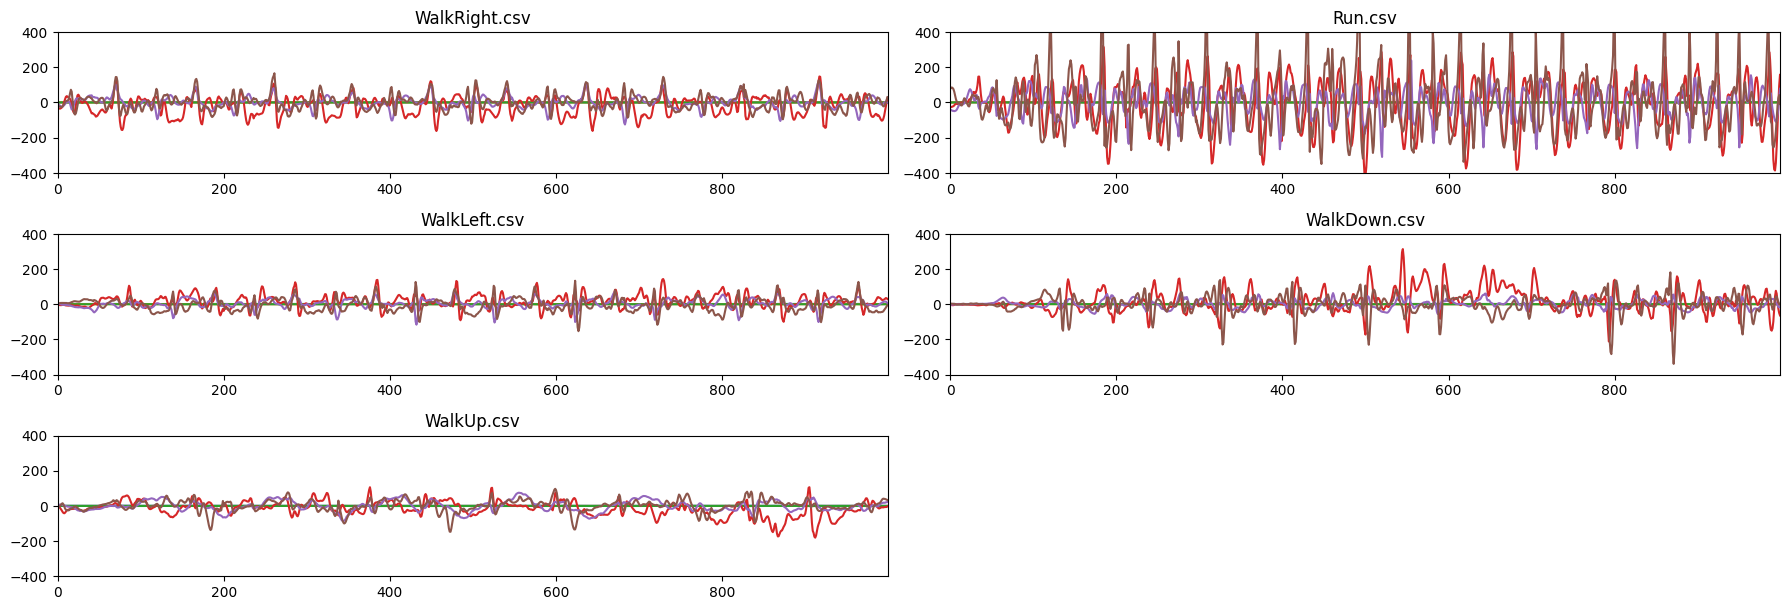

In [47]:
import random
import matplotlib.pyplot as plt
%matplotlib inline

# Plot some captures
random.seed(10)
unique_rands = random.sample(range(len(x_recordings)), 5)
plt.figure(figsize=(18, 10))
for i, n in enumerate(unique_rands):
    plt.subplot(5, 2, i + 1)
    plt.margins(x=0, y=-0.25)
    plt.plot(x_recordings[n])
    plt.ylim(-400, 400)  # 4000 mg acc. range
    plt.title(recordings_filenames[n].split('/')[-1])
plt.tight_layout()
plt.show()

## Frame data

Each capture is framed into smaller windows. The window size will be the input dimension for the neural network. Optional overlapping can be added to further increase the number of points in our data for training and testing.

Here we are dividing the dataset into 1 second frames (26 samples at 26 Hz):

In [48]:
import numpy as np

def frame(x, frame_len, hop_len):
    '''Slice a 3D data array into (overlapping) frames.

    Example
    --------
    >>> x = np.array([[0, 1, 2],
                      [10, 11, 12],
                      [20, 21, 22],
                      [30, 31, 32],
                      [40, 41, 42],
                      [50, 51, 52],
                      [60, 61, 62]])
    >>> frames = x.frame(x, 3, 2)
    >>> x.shape
    (7, 3)
    >>> frames.shape
    (3, 3, 3)
    '''

    assert(x.shape == (len(x), 6))
    assert(x.shape[0] >= frame_len)
    assert(hop_len >= 1)

    n_frames = 1 + (x.shape[0] - frame_len) // hop_len
    shape = (n_frames, frame_len, x.shape[1])
    strides = ((hop_len * x.strides[0],) + x.strides)
    return np.lib.stride_tricks.as_strided(x, shape=shape, strides=strides)

x_frames = []
y_frames = []
for i in range(x_recordings.shape[0]):
    # frames = frame(x_recordings[i], 26, 26) # no overlap
    frames = frame(x_recordings[i], 26, 13) # 50% overlap
    x_frames.append(frames)
    y_frames.append(np.full(frames.shape[0], y_recordings[i]))

print(np.array(x_frames).shape)
x_frames = np.concatenate(x_frames)
y_frames = np.concatenate(y_frames)
print(x_frames.shape)

# Each output label is an integer between 0 and 2:
print(y_frames.shape)
print(labels)

(6, 75, 26, 6)
(450, 26, 6)
(450,)
['Run', 'WalkDown', 'WalkForward', 'WalkLeft', 'WalkRight', 'WalkUp']


## Preprocessing the dataset

To improve the model's performance, it is recommended to perform some kind of pre-processing on the input data before feeding them to the neural network model. Data pre-processing can include filtering, gravity rotation and/or suppression as it is done in [FP-AI-SENSING1]. In this example, a simple data scaling will suffice.

Data scaling can be achieved by normalizing or standardizing input data. In this example, data is normalized into floating point values between `-1.0` and `1.0` by dividing them by the sensor's full range (`4000 mg`).

[FP-AI-SENSING1]:https://www.st.com/en/embedded-software/fp-ai-sensing1.html

In [49]:
# Normalize input data between [-1;1]
x_frames_normed = x_frames / 4000

### Preparing the dataset (train, test, split)
The dataset is split into a _train_ and _test_ set. The data is first shuffled and then split with 25% reserved for model evaluation and testing purposes.

In [50]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    x_frames_normed, y_frames, test_size=0.25)

print("Trainning samples:", x_train.shape)
print("Testing samples:", x_test.shape)

Trainning samples: (337, 26, 6)
Testing samples: (113, 26, 6)


## Creating the model

Let's create a classifier model using Keras.

Build the tf.keras.Sequential model by stacking layers. Choose an optimizer and loss function for training:

In [51]:
## Conv1D based model
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=16, kernel_size=3, activation='relu', input_shape=(26, 6)),
  tf.keras.layers.Conv1D(filters=8, kernel_size=3, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(6, activation='softmax')
])
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(x_train, y_train, epochs=30)
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)

print("Test loss:", test_loss)
print("Test acc:", test_acc)
model.summary()

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1560 - loss: 1.7899
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1975 - loss: 1.7836 
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1935 - loss: 1.7770 
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1884 - loss: 1.7714 
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1891 - loss: 1.7580 
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1702 - loss: 1.7442 
Epoch 7/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1947 - loss: 1.7094 
Epoch 8/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1967 - loss: 1.6540 
Epoch 9/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2642 - loss: 1.5919 
Epoch 10/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2792 - loss: 1.5927 
Epoch 11/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3120 - loss: 1.5496 
Epoch 12/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3130 - los

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)                    │ (None, 24, 16)              │             304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_7 (Conv1D)                    │ (None, 22, 8)               │             392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 22, 8)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 176)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │          11,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 37,244 (145.49 KB)

 Trainable params: 12,414 (48.49 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 24,830 (97.00 KB)

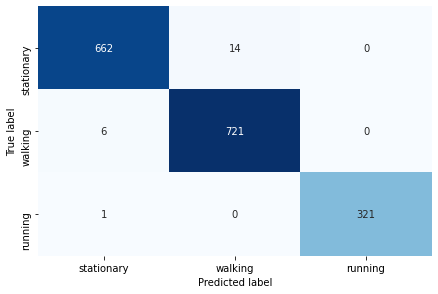

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Y_pred = model.predict(x_test)
y_pred = np.argmax(Y_pred, axis=1)
confusion_matrix = tf.math.confusion_matrix(y_test, y_pred)

plt.figure()
sns.heatmap(confusion_matrix,
            annot=True,
            xticklabels=labels,
            yticklabels=labels,
            cmap=plt.cm.Blues,
            fmt='d', cbar=False)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
# Save the model into an HDF5 file ‘model.h5’
model.save('model.h5')